# Прогнозирование температуры звезды

Цель проекта - с помощью предоставленных данных обучить нейросеть и предсказать температуру на поверхности обнаруженных звёзд. 

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from math import ceil
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

np.random.seed(0)

In [2]:
df = pd.read_csv('/datasets/6_class.csv', index_col=0)
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Согласно документации к данным:
* `Temperature (K)` — температура звезды, целевой признак;
* `Luminosity(L/Lo)` — светимость звезды относительно Солнца.;  
* `Radius(R/Ro)` — радиус звезды относительно радиуса Солнца.;
* `Absolute magnitude(Mv)` — физическая величина, характеризующая блеск звезды;
* `Star type` — тип звезды;
* `Star color` — цвет звезды, который определяют на основе спектрального анализа.



| Тип звезды  | Номер |
| ------------- | ------------- |
| Коричневый карлик  | 0  |
| Красный карлик | 1  |
| Белый карлик  | 2  |
| Звёзды главной последовательности  | 3  |
| Сверхгигант | 4  |
| Гипергигант | 5  |

In [3]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


## Предобработка и анализ данных

Приведем названия столбцов к единому стилю:

In [4]:
df.columns = ['temperature', 'luminosity', 'radius', 'abs_magnitude', 'star_type', 'star_color']

Проверим на наличие пропусков и дубликатов:

In [5]:
df.isna().sum()

temperature      0
luminosity       0
radius           0
abs_magnitude    0
star_type        0
star_color       0
dtype: int64

In [6]:
df.duplicated().sum()

0

В столбцах со значениями со светимостью и радиусом нам даны относительные значения, для начала преодбразуем значения в абсолютные:

In [7]:
L0 = 3.828e26
R0 = 6.9551e8

In [8]:
df['luminosity'] = df['luminosity']*L0
df['radius'] = df['radius']*R0

Посмотрим на количественные переменные, но сначала определим функцию для построения графиков распределения:

In [9]:
def distr(data, title, x, y):
    plt.figure(figsize=(5, 4))
    sns.histplot(data=data, kde=True, bins=50)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()


    plt.figure(figsize=(8, 1))
    sns.boxplot(x=data)
    plt.xlabel(x)
    plt.show()

Построим графики для всех значений:

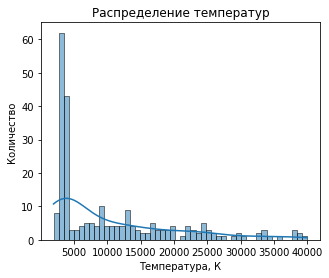

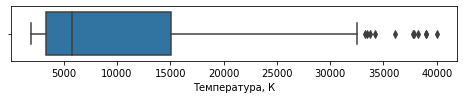

In [10]:
distr(df['temperature'], 'Распределение температур', 'Температура, К', 'Количество')

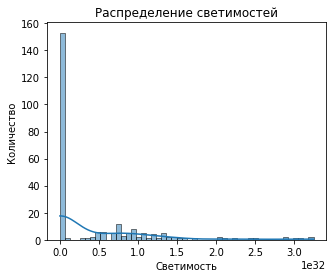

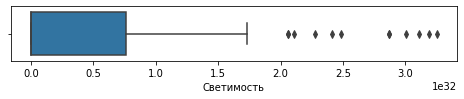

In [11]:
distr(df['luminosity'], 'Распределение светимостей', 'Светимость', 'Количество')

Видим пик около нуля, что указывает на большое кол-во звезд с малой светимостью.

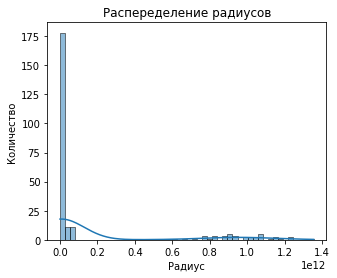

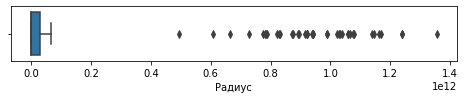

In [12]:
distr(df['radius'], 'Распеределение радиусов', 'Радиус', 'Количество')

В поле с радиусами можем наблюдать большое кол-во выбросов, но удалить их мы не можем, тк это приведет к искажению данных.

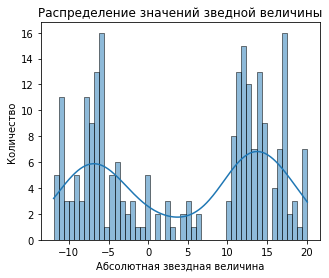

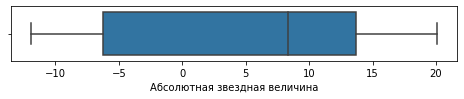

In [13]:
distr(df['abs_magnitude'], 'Распределение значений зведной величины', 'Абсолютная звездная величина', 'Количество')

Здесь видим 2 пика. Так как в данных преобладают звезды с малой светимостью и температурой, то есть тусклые звёзды, предположим, что у них не может быть слишком большого отрицательного значения звездной величины, поэтому все, что меньше -5, примем за неверную запись данных и поменяем знак. Также уберем значения больше 10.

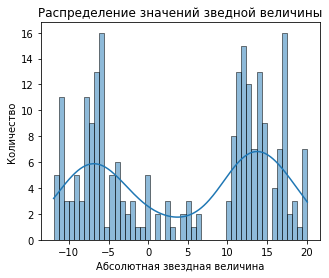

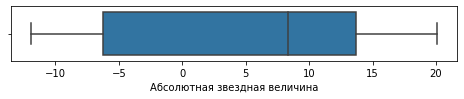

In [14]:
distr(df['abs_magnitude'], 'Распределение значений зведной величины', 'Абсолютная звездная величина', 'Количество')

Далее рассмотрим категориальные переменные - тип и цвет звезды:

In [15]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Присутствуют одинаковые значения, записаные в разном регистре и с разными разделителями, поправим это:

In [16]:
df['star_color']= df['star_color'].str.strip() # убираем пробел в конце
df['star_color']= df['star_color'].str.lower() # приводим к нижнему регистру

In [17]:
def fix_value(cell):
     cell = cell.replace(' ', '-')  # функция, заменяющая все пробелы на дефисы
     return cell 

df['star_color'] = df['star_color'].apply(fix_value)

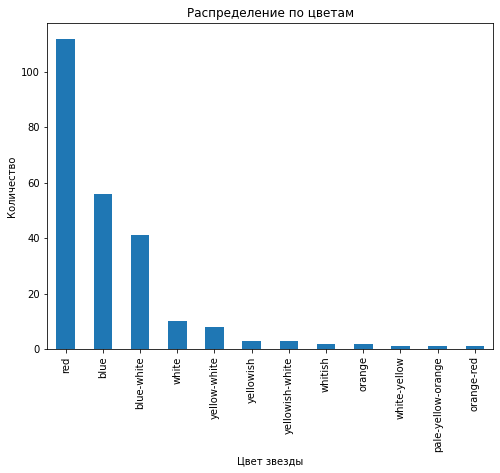

In [18]:
df['star_color'].value_counts().plot(kind='bar', 
                                     title='Распределение по цветам', 
                                     xlabel='Цвет звезды', 
                                     ylabel='Количество', 
                                     figsize=(8,6));

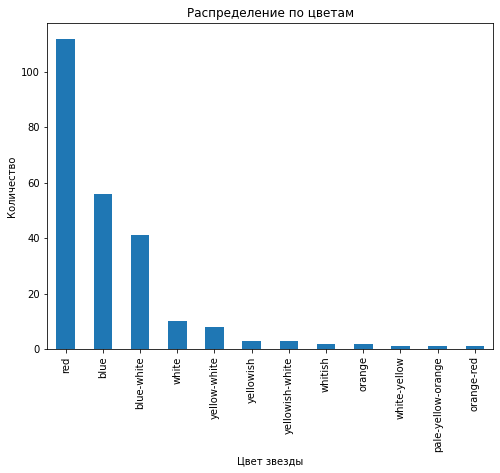

In [19]:
df['star_color'].value_counts().plot(kind='bar', 
                                     title='Распределение по цветам', 
                                     xlabel='Цвет звезды', 
                                     ylabel='Количество', 
                                     figsize=(8,6));

Больше всего в выборке представлено красных звезд, что соответсвует большому числу звезд с малой светимостью на графике выше.

Далее посмторим на распределение типов:

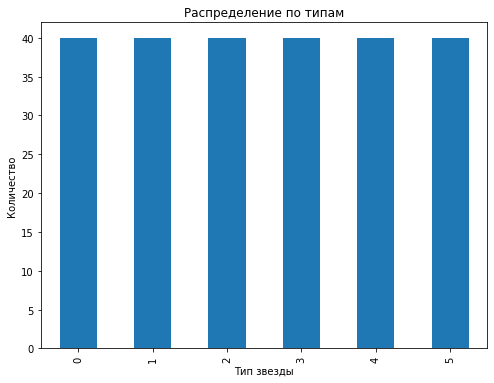

In [20]:
df['star_type'].value_counts().plot(kind='bar', 
                                     title='Распределение по типам', 
                                     xlabel='Тип звезды', 
                                     ylabel='Количество', 
                                     figsize=(8,6));

Каждому типу соответсвует одинаковое количество звезд.

## Построение базовой нейронной сети

Разделим исходные данные на обучающую и тестовую выборки - выделим под обучающую 85% и  15% на тестовую.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('temperature', axis=1), 
                                                    df['temperature'], 
                                                    train_size=0.85, 
                                                    random_state=42, 
                                                    shuffle=True)

Далее проведем масштабирование количественных данных:

In [22]:
numeric = ['luminosity', 'radius', 'abs_magnitude']

scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])


Закодируем категориальные данные с OneHotEncoder:

In [23]:
categorial = ['star_color', 'star_type']

tmp_train = x_train[categorial]
tmp_test= x_test[categorial]


encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(x_train[categorial])

tmp_train = pd.DataFrame(encoder_ohe.transform(x_train[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names(),
                                   index=x_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(x_test[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names(),
                                   index=x_test.index)

x_train.drop(categorial, axis=1, inplace=True)
x_train = x_train.join(tmp_train)

x_test.drop(categorial, axis=1, inplace=True)
x_test = x_test.join(tmp_test)

Cоздаем тензоры признаков:

In [24]:
x_train_torch = torch.FloatTensor(x_train.values)
y_train_torch = torch.FloatTensor(y_train.values)
x_test_torch = torch.FloatTensor(x_test.values)
y_test_torch = torch.FloatTensor(y_test.values)

Инициализируем нейронную сеть, состоящую из входных нейронов, двух скрытых слоев и выходного слоя:

In [25]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.act1 = nn.Tanh()
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        
        out = self.fc2(out)
        out = self.act2(out)
        
        out = self.fc3(out)
        
        return out

Создадим функцию для обучения нейронной сети и вывода RMSE:

In [26]:
def net_learn(num_epochs, net):
    rmse_best = 50000
    rmse_list = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
 
        preds = net.forward(x_train_torch).flatten()
            
        loss_value = loss(preds, y_train_torch)

        loss_value.backward()
            
        optimizer.step()
    
      #  if epoch % 150 ==0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(x_test_torch)
        rmse = mean_squared_error(y_test_torch.detach().numpy(), test_preds.detach().numpy(), squared=False)
        rmse_list.append(rmse)
        if rmse < rmse_best:
            rmse_best = rmse
            test_preds_best = test_preds 
            best_epoch = epoch 
    print('RMSE:', round(rmse_best, 3), '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
    return test_preds_best, rmse_list

Зададим количество нейронов на каждом слое сети:

In [27]:
n_in_neurons = x_train.shape[1]
n_hidden_neurons = list(range(300, 1050, 50))      # оптимальное кол-во нейронов для 
n_out_neurons = 1                                  # скрытых слоев будем находить перебором от 300 до 1000

loss = nn.MSELoss()                                # задаем функцию потерь

num_epochs = 1500
comb = 10                                        # число комбинаций для перебора

Далее перебираем случайные комбинации и находим оптимальную:

In [28]:
for c in range(comb):
    hidden_size_1 = random.choice(n_hidden_neurons)    
    hidden_size_2 = random.choice(n_hidden_neurons)
    print('hidden 1 =',hidden_size_1, 'hidden 2 =',hidden_size_2)
    net = Net(n_in_neurons, hidden_size_1, hidden_size_2, n_out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    test_preds, rmse_list = net_learn(num_epochs, net)
    print('---------------------------')    

hidden 1 = 450 hidden 2 = 950
RMSE: 4241.354 | ep 1499 from 1500 | best_epoch: 1214
---------------------------
hidden 1 = 800 hidden 2 = 300
RMSE: 4242.716 | ep 1499 from 1500 | best_epoch: 1326
---------------------------
hidden 1 = 850 hidden 2 = 950
RMSE: 4219.016 | ep 1499 from 1500 | best_epoch: 1076
---------------------------
hidden 1 = 550 hidden 2 = 550
RMSE: 4253.008 | ep 1499 from 1500 | best_epoch: 1225
---------------------------
hidden 1 = 450 hidden 2 = 300
RMSE: 4244.402 | ep 1499 from 1500 | best_epoch: 1423
---------------------------
hidden 1 = 600 hidden 2 = 1000
RMSE: 4244.128 | ep 1499 from 1500 | best_epoch: 1158
---------------------------
hidden 1 = 850 hidden 2 = 600
RMSE: 4210.365 | ep 1499 from 1500 | best_epoch: 1296
---------------------------
hidden 1 = 400 hidden 2 = 400
RMSE: 4262.691 | ep 1499 from 1500 | best_epoch: 1330
---------------------------
hidden 1 = 950 hidden 2 = 850
RMSE: 4240.324 | ep 1499 from 1500 | best_epoch: 1097
-------------------

Оптимальной яляется комбинация 850 нейронов на первом слое и 600 на втором, дающая значение RMSE 4210.365, что укладывается в заданную границу в 4500.

Теперь построим график "Факт — Прогноз", где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах:

In [29]:
net = Net(n_in_neurons, 650, 600, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
test_preds, rmse_list = net_learn(num_epochs, net)

RMSE: 4232.83 | ep 1499 from 1500 | best_epoch: 1249


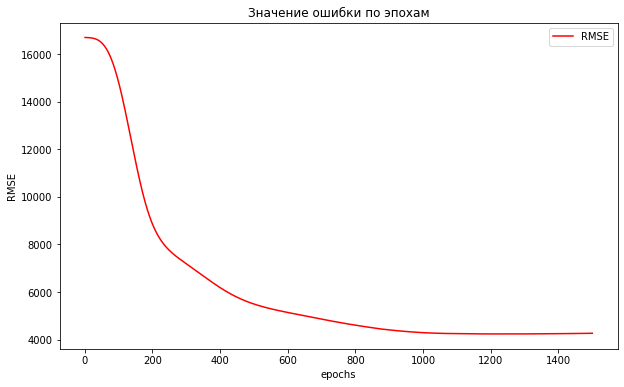

In [30]:
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=[10,6])
sns.lineplot(x=epochs, y=rmse_list, label='RMSE', color='red')
plt.legend()
plt.title('Значение ошибки по эпохам')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.show()

Из графика видим, что модель перестает обучаться примерно после 1050 эпохи.

In [31]:
test_preds = pd.DataFrame(test_preds.detach().numpy(), columns=['temperature'])  # преобразуем данные
y_test = pd.DataFrame((y_test), columns=['temperature']).reset_index().drop('index', axis=1)

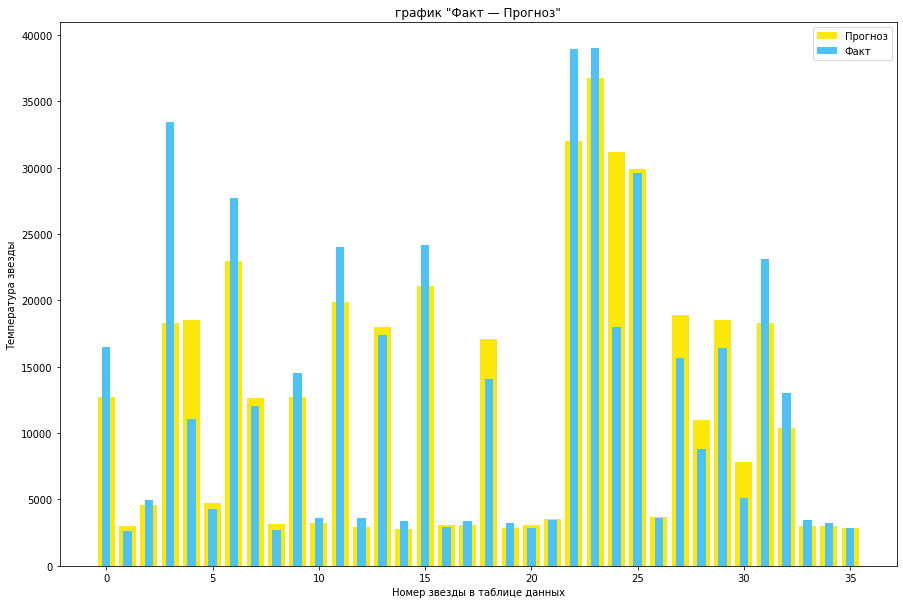

In [32]:
fig, ax = plt.subplots(figsize=[15,10])
plt.bar(x=test_preds.index, height=test_preds['temperature'], color='#fce80b' , label='Прогноз')
plt.bar(x=y_test.index, height=y_test['temperature'], color='#4cc2f6', label='Факт', width= 0.4)
plt.title('график "Факт — Прогноз"')
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
ax.legend()
plt.show()

## Улучшение нейронной сети

Посмотрим, как будет работать сеть при обучении батчами, для этого дополним функцию net_learn так, чтобы использовать батчи.
Оьбъявим класс EarlyStopping, который будет предоствращать переобучение и останавливать цикл обучения по достижению оптимального значения:

In [33]:
class EarlyStopping():
    def __init__(self, patience=7, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss

            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
             self.counter += 1
                
             if self.counter >= self.patience:
                print('Early stopping')
                self.early_stop = True

Дополним функцию net_learn разбиением на батчи и спользуем early stopping:

In [34]:
def net_learn_batches(num_epochs, net):
    early_stopping = EarlyStopping() 
    rmse_best = 50000
    for epoch in range(num_epochs):
        net.train()
        for batch in train_dataloader:
            data_train, temperature_train = batch  
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.sqrt(loss(preds, temperature_train))
            loss_value.backward()
            optimizer.step()

        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch
  
                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        rmse = mean_squared_error(y_test, predicted_temp, squared=False)
        rmse_list.append(rmse)
        if rmse < rmse_best:
            rmse_best = rmse
            best_epoch = epoch
            test_preds_best = predicted_temp
        early_stopping(rmse)

        if early_stopping.early_stop:
            break 
    print('RMSE:', round(rmse_best, 3), '| ep', epoch, 'from', num_epochs, '| best_epoch:', best_epoch)
    return test_preds_best

In [35]:
class Net_Batch(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(Net_Batch, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)

        self.act1 = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
        self.act2 = nn.ReLU()
        
        
        self.fc3 = nn.Linear(hidden_size2, num_classes) 
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.bn1(out)
       
        out = self.fc2(out)
        out = self.act2(out)
        
        out = self.fc3(out)
        
        return out

Попробуем найти оптимальный размер батча с помощью перебора по списку:

In [36]:
batch_size = list(range(15, len(x_train_torch), 25))

dataset_train = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
dataset_test = torch.utils.data.TensorDataset(x_test_torch, y_test_torch)

In [37]:
for b in batch_size:
    train_dataloader = DataLoader(dataset_train, batch_size=b, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(dataset_test, batch_size=b, num_workers=0)  
    print('batch_size:', b)    
    net = Net_Batch(n_in_neurons, 650, 1000, n_out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    batch_test_preds = net_learn_batches(num_epochs, net)
    print('---------------------------')

batch_size: 15
Early stopping
RMSE: 4770.271 | ep 24 from 1500 | best_epoch: 17
---------------------------
batch_size: 40
Early stopping
RMSE: 4665.708 | ep 44 from 1500 | best_epoch: 37
---------------------------
batch_size: 65
Early stopping
RMSE: 4984.848 | ep 65 from 1500 | best_epoch: 58
---------------------------
batch_size: 90
Early stopping
RMSE: 5404.781 | ep 64 from 1500 | best_epoch: 57
---------------------------
batch_size: 115
Early stopping
RMSE: 5639.133 | ep 89 from 1500 | best_epoch: 82
---------------------------
batch_size: 140
Early stopping
RMSE: 5594.417 | ep 88 from 1500 | best_epoch: 81
---------------------------
batch_size: 165
Early stopping
RMSE: 5577.667 | ep 85 from 1500 | best_epoch: 78
---------------------------
batch_size: 190
Early stopping
RMSE: 5442.63 | ep 100 from 1500 | best_epoch: 93
---------------------------


Лучший размер батча 40, однако, обучение батчами не улучшает значение RMSE, и более того, показывает себя хуже и обучается дольше.

Поэтому далее будем использовать исходную функцию net_learn.

Далее попробуем инициализировать сеть с разными вариантами параметра в dropout, увеличив кол-во эпох: 

In [38]:
dropout = [0.5, 0.7, 0.8, 0.9] 
comb = 10
num_epochs = 1200

In [39]:
for c in range(comb):
    p1 = random.choice(dropout)
    p2 = random.choice(dropout)
    print('drop =', p1, p2)
    class Net_Dropout(nn.Module):
        def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
            super(Net_Dropout, self).__init__()
        
            self.fc1 = nn.Linear(input_size, hidden_size1)
            self.act1 = nn.Tanh()
            self.dp1 = nn.Dropout(p=p1)
        
            self.fc2 = nn.Linear(hidden_size1, hidden_size2) 
            self.act2 = nn.ReLU()
            self.dp2 = nn.Dropout(p=p2)
        
            self.fc3 = nn.Linear(hidden_size2, num_classes) 
        
        
        def forward(self, x):
            
            out = self.fc1(x)
            out = self.act1(out)
            out = self.dp1(out)
        
            out = self.fc2(out)
            out = self.act2(out)
            out = self.dp2(out)
            
            out = self.fc3(out)
            return out
           
    net = Net_Dropout(n_in_neurons, 950, 750, n_out_neurons)
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
    drop_test_preds = net_learn(num_epochs, net)
    
    print('---------------------------')    

drop = 0.5 0.7
RMSE: 4226.769 | ep 1199 from 1200 | best_epoch: 1153
---------------------------
drop = 0.5 0.7
RMSE: 4225.612 | ep 1199 from 1200 | best_epoch: 1128
---------------------------
drop = 0.8 0.5
RMSE: 4242.861 | ep 1199 from 1200 | best_epoch: 1139
---------------------------
drop = 0.7 0.8
RMSE: 4246.327 | ep 1199 from 1200 | best_epoch: 1124
---------------------------
drop = 0.7 0.7
RMSE: 4243.878 | ep 1199 from 1200 | best_epoch: 1110
---------------------------
drop = 0.5 0.7
RMSE: 4239.404 | ep 1199 from 1200 | best_epoch: 1160
---------------------------
drop = 0.7 0.8
RMSE: 4231.32 | ep 1199 from 1200 | best_epoch: 1097
---------------------------
drop = 0.9 0.5
RMSE: 4206.863 | ep 1199 from 1200 | best_epoch: 1184
---------------------------
drop = 0.5 0.9
RMSE: 4251.01 | ep 1199 from 1200 | best_epoch: 1109
---------------------------
drop = 0.5 0.7
RMSE: 4212.136 | ep 1199 from 1200 | best_epoch: 1175
---------------------------


Лучше всего показывают себя значения Dropout 0.8 и 0.5, однако результаты у базовой модели лучше. 

In [40]:
drop_test_preds = pd.DataFrame(drop_test_preds[0].detach().numpy(), columns=['temperature'])

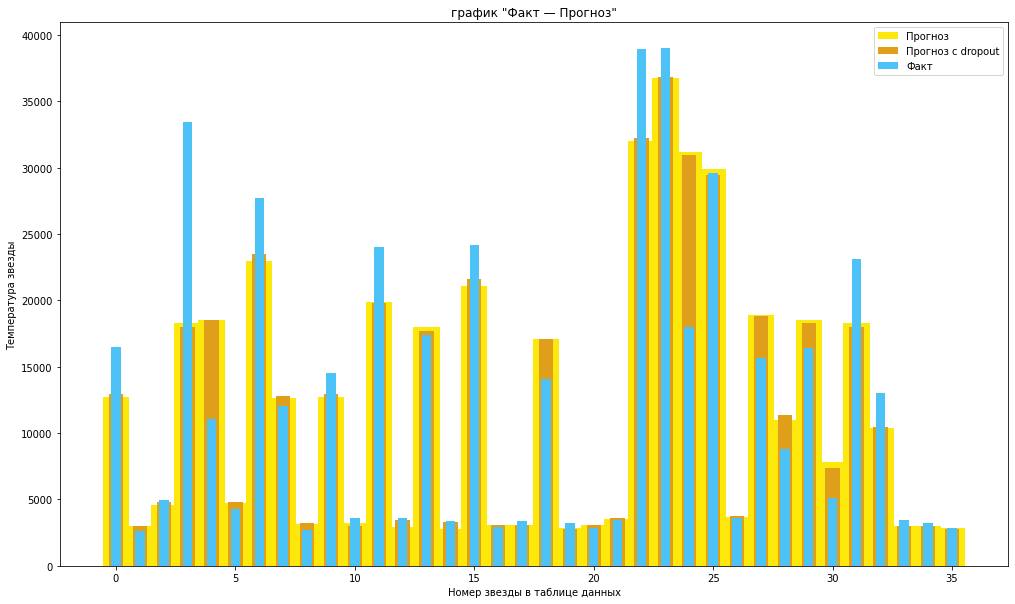

In [41]:
fig, ax = plt.subplots(figsize=[17,10])
plt.bar(x=test_preds.index, height=test_preds['temperature'], color='#fce80b' , label='Прогноз', width= 1.1)
plt.bar(x=drop_test_preds.index, height=drop_test_preds['temperature'], color='#e09f1b' , label='Прогноз c dropout', width= 0.6)

plt.bar(x=y_test.index, height=y_test['temperature'], color='#4cc2f6', label='Факт', width= 0.4)
plt.title('график "Факт — Прогноз"')
plt.xlabel('Номер звезды в таблице данных')
plt.ylabel('Температура звезды')
ax.legend()
plt.show()

Обе модели показывают практически одинаковые результаты, причем прогнозы более точны на малых значениях температуры до 5000 К, что связано с пребладанием в исходных данных малых значений температуры, радиуса и светимостей.

## Выводы

На таком малом обьеме данных нецелесообразно использовать обучение сети с помощью батчей, а так же проводить регуляризацию - обе модели показывают примерно одинаковые значения RMSE ~ 4250, что укладывается в заданную границу 4500.